# RQ: How do gRPC interceptors affect throughput and latency in microservice architectures?

In [103]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load & Clean Data

In [104]:
# 0 = no interceptor
# 1 = interceptor
# postion in name: 
# 001 = Open Telemetry
# 010 = Prometheus
# 100 = Logging

# -------------- loading data -------------- #

result_000 = '../results/results_000.csv'   # no interceptor
result_001 = '../results/results_001.csv'   # Open Telemetry
result_010 = '../results/results_010.csv'   # Prometheus
result_011 = '../results/results_011.csv'   # Open Telemetry + Prometheus
result_100 = '../results/results_100.csv'   # Logging
result_101 = '../results/results_101.csv'   # Open Telemetry + Logging
result_110 = '../results/results_110_2.csv'   # Prometheus + Logging
result_111 = '../results/results_111_2.csv'   # Open Telemetry + Prometheus + Logging

results = [result_000, result_001, result_111]

data_000 = pd.read_csv(result_000)
data_001 = pd.read_csv(result_001)
data_010 = pd.read_csv(result_010)
data_011 = pd.read_csv(result_011)
data_100 = pd.read_csv(result_100)
data_101 = pd.read_csv(result_101)
data_110 = pd.read_csv(result_110)
data_111 = pd.read_csv(result_111)

datasets = [data_000, data_001, data_010, data_011, data_100, data_101, data_110, data_111]

# -------------- cleaning data -------------- #

# Helper function to convert latency string to float
def convert_latency_to_ms(latency_str):
    if 'ms' in latency_str:
        return float(latency_str.replace('ms', '').strip())
    elif 'µs' in latency_str:
        return float(latency_str.replace('µs', '').strip()) / 1000
    else:
        return 0

# Apply the function to Min and Max Latency columns
for data in datasets:
    # remove the row of zeroes at the beginning (warmup/init)
    data.drop([0], inplace=True)

    data['Average Latency'] = data['Average Latency'].apply(convert_latency_to_ms)
    data['Max Latency'] = data['Max Latency'].apply(convert_latency_to_ms)
    data['Min Latency'] = data['Min Latency'].apply(convert_latency_to_ms)


In [105]:
data_000.head(10)

,Timestamp,Total Requests,Concurrent Requests,Average Latency,Max Latency,Min Latency,Avg. Throughput req/s,Time Elapsed
1,2024-01-29 15:52:00.560615051 +0000 UTC m=+50....,100000,1,0.309119,10.157810,0.175555,3234.998458,31.324071485s
2,2024-01-29 15:52:19.118192646 +0000 UTC m=+68....,100000,2,0.365666,3.510069,0.165500,2734.735431,18.553422741s
3,2024-01-29 15:52:33.197353116 +0000 UTC m=+82....,100000,3,0.416141,3.616407,0.164575,2403.031008,14.074235516s
4,2024-01-29 15:52:44.261136484 +0000 UTC m=+93....,100000,4,0.435781,5.147494,0.172570,2294.728231,11.059191641s
5,2024-01-29 15:52:54.056525366 +0000 UTC m=+103...,100000,5,0.482433,4.269935,0.174455,2072.823650,9.791870099s
6,2024-01-29 15:53:02.71154691 +0000 UTC m=+112....,100000,6,0.511383,3.661470,0.159664,1955.479767,8.651489173s
7,2024-01-29 15:53:10.584721947 +0000 UTC m=+120...,100000,7,0.542458,3.048941,0.158618,1843.459748,7.869473893s
8,2024-01-29 15:53:17.951416149 +0000 UTC m=+127...,100000,8,0.580261,3.609160,0.171795,1723.361839,7.363163481s
9,2024-01-29 15:53:24.981510586 +0000 UTC m=+134...,100000,9,0.622512,4.525304,0.172016,1606.394675,7.026047975s
10,2024-01-29 15:53:31.548548881 +0000 UTC m=+141...,100000,10,0.646093,4.476315,0.189130,1547.764700,6.563543389s


## Plotting

### Q: How does each **single** interceptor affect throughput?

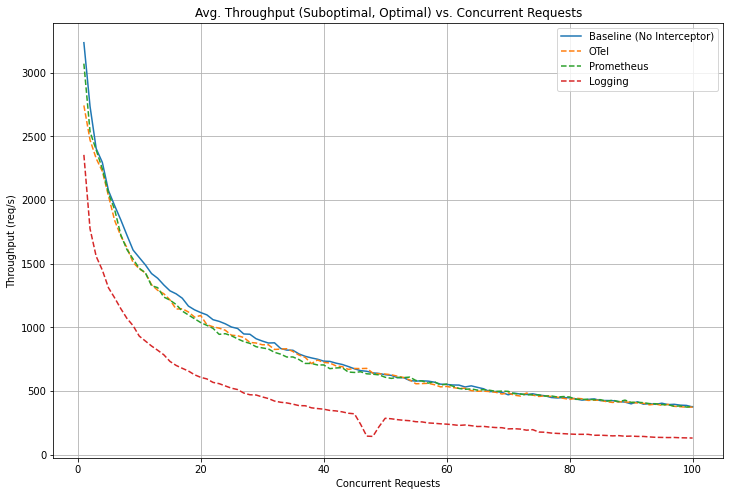

In [110]:
plt.figure(figsize=(12, 8))
plt.plot(data_000['Concurrent Requests'], data_000['Avg. Throughput req/s'],  label='Baseline (No Interceptor)') #marker='o',
plt.plot(data_001['Concurrent Requests'], data_001['Avg. Throughput req/s'],  linestyle='--', label='OTel') #marker='x',
plt.plot(data_010['Concurrent Requests'], data_010['Avg. Throughput req/s'],  linestyle='--', label='Prometheus') #marker='^',
plt.plot(data_100['Concurrent Requests'], data_100['Avg. Throughput req/s'],  linestyle='--', label='Logging') #marker='s',

plt.title('Avg. Throughput (Suboptimal, Optimal) vs. Concurrent Requests')
plt.xlabel('Concurrent Requests')
plt.ylabel('Throughput (req/s)')
#plt.yscale('log')  # Set y scale to logarithmic
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.grid(True)
plt.show()

### Q: How does each **single** interceptor affect latency?

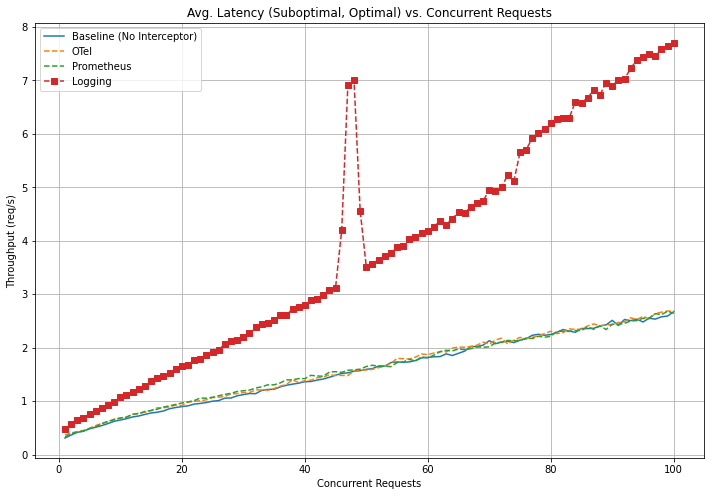

In [111]:
plt.figure(figsize=(12, 8))
plt.plot(data_000['Concurrent Requests'], data_000['Average Latency'],  label='Baseline (No Interceptor)') #marker='o',
plt.plot(data_001['Concurrent Requests'], data_001['Average Latency'],  linestyle='--', label='OTel') #marker='x',
plt.plot(data_010['Concurrent Requests'], data_010['Average Latency'],  linestyle='--', label='Prometheus') #marker='^',
plt.plot(data_100['Concurrent Requests'], data_100['Average Latency'],  linestyle='--', label='Logging') #marker='s',

plt.title('Avg. Latency (Suboptimal, Optimal) vs. Concurrent Requests')
plt.xlabel('Concurrent Requests')
plt.ylabel('Throughput (req/s)')
# plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.grid(True)
plt.show()

### Q: How do **combinations** of interceptors affect throughput?

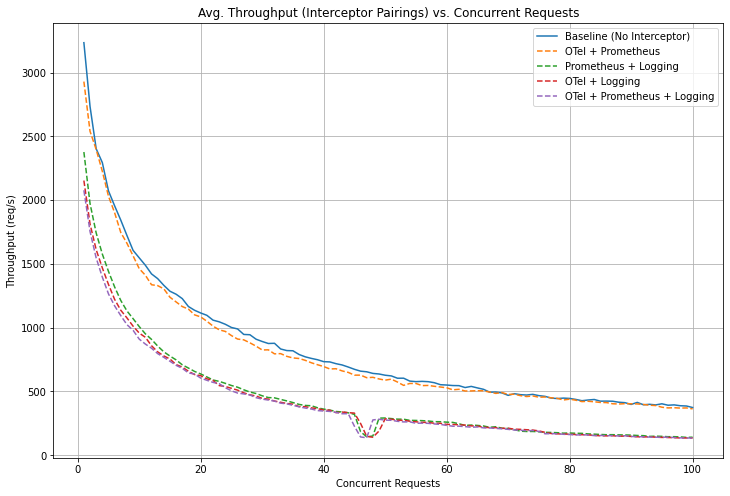

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(data_000['Concurrent Requests'], data_000['Avg. Throughput req/s'],  label='Baseline (No Interceptor)') #marker='o',
plt.plot(data_011 ['Concurrent Requests'], data_011 ['Avg. Throughput req/s'],  linestyle='--', label='OTel + Prometheus') #marker='o',
plt.plot(data_110 ['Concurrent Requests'], data_110 ['Avg. Throughput req/s'],  linestyle='--', label='Prometheus + Logging') #marker='x',
plt.plot(data_101 ['Concurrent Requests'], data_101 ['Avg. Throughput req/s'],  linestyle='--', label='OTel + Logging') #marker='^',
plt.plot(data_111 ['Concurrent Requests'], data_111 ['Avg. Throughput req/s'],  linestyle='--', label='OTel + Prometheus + Logging') #marker='^',

plt.title('Avg. Throughput (Interceptor Pairings) vs. Concurrent Requests')
plt.xlabel('Concurrent Requests')
plt.ylabel('Throughput (req/s)')
#plt.yscale('log')  # Set y scale to logarithmic
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.grid(True)
plt.show()


### Q: How do **combinations** of interceptors affect latency?

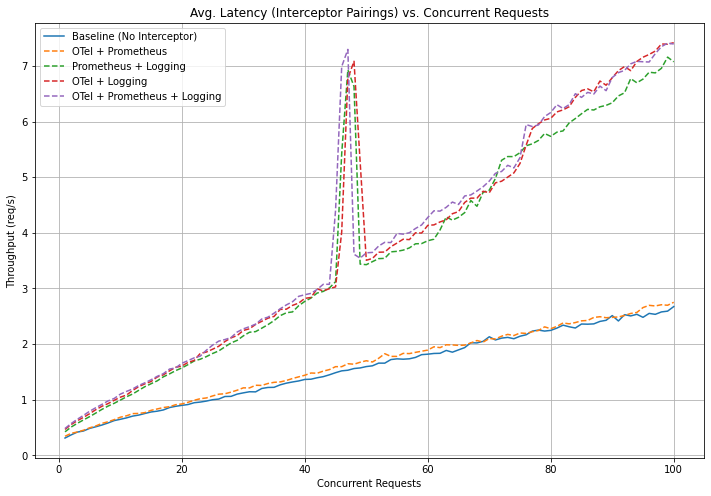

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(data_000['Concurrent Requests'], data_000['Average Latency'],  label='Baseline (No Interceptor)') #marker='o',
plt.plot(data_011 ['Concurrent Requests'], data_011 ['Average Latency'],  linestyle='--', label='OTel + Prometheus') #marker='o',
plt.plot(data_110 ['Concurrent Requests'], data_110 ['Average Latency'],  linestyle='--', label='Prometheus + Logging') #marker='x',
plt.plot(data_101 ['Concurrent Requests'], data_101 ['Average Latency'],  linestyle='--', label='OTel + Logging') #marker='^',
plt.plot(data_111 ['Concurrent Requests'], data_111 ['Average Latency'],  linestyle='--', label='OTel + Prometheus + Logging') #marker='^',

plt.title('Avg. Latency (Interceptor Pairings) vs. Concurrent Requests')
plt.xlabel('Concurrent Requests')
plt.ylabel('Throughput (req/s)')
# plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.grid(True)
plt.show()
